# SAFECOM Trend Analysis

This notebook provides an example of the trend analysis portion of the Hazard Extraction and Analysis of Trends framework. Trend analysis is applied the the SAFECOM dataset of wildfire aviation mishaps, available here: https://www.safecom.gov/ 

This example uses the trend analysis module from MIKA's knowledge discovery toolkit, as well as the Data utility and SAFECOM utilities. 

Prior to this analysis, hazard extraction is performed using the topic model plus module.

# Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

c:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils import Data
from mika.utils.SAFECOM import *

c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\

# SAFECOM Data

Prior to performing HEAT, the SAFECOM dataset needs to be loaded in and cleaned.

The MIKA Data class is used for loading in the preprocessed data. 

Additional cleaning includes:
- identifying event occurrence year
- removing non-fire reports
- correcting regions

In [3]:
list_of_attributes = ['Narrative']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join('topic_model_results','preprocessed_data.csv')
safecom = Data()
safecom.load(file, preprocessed=True, id_col=document_id_col, text_columns=list_of_attributes)
preprocessed_df = safecom.data_df

In [4]:
#extract event occurrence year
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [5]:
preprocessed_df = preprocessed_df.loc[(preprocessed_df['Year'].astype(int)<2021) & (preprocessed_df['Year'].astype(int)>1994)].reset_index(drop=True)

In [6]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
preprocessed_df = preprocessed_df.loc[~preprocessed_df['Tracking #'].isin(ids_to_drop)].reset_index(drop=True)
print(len(ids_to_drop))

1983


In [7]:
#correct regions to match corresponding USFS regions
preprocessed_df = correct_regions(preprocessed_df)

In [8]:
preprocessed_df

,Agency,Region,Location,Date,Date Submitted,Tracking #,Mission Type,Persons Onboard,Departure Point,Destination,...,UAS,Accident,Airspace,Maintenance,Mishap Prevention,Raw_Narrative,Year,Day,Month,region_corrected
0,Bureau of Land Management (BLM),Alaska State Office,Fairbanks,05/10/1995,,95-0002,"Fire, Smokejumper",1.0,Fairbanks,,...,,,Intrusion,,,On a practice parachute jump a single engine a...,1995,10,05,Region 10 Alaska Region
1,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/10/1995,,95-0003,"Fire, Smokejumper",4.0,Birch Hill,,...,,,Intrusion,,,NXXXXX 5-10-95 A small airplane flew thr...,1995,10,05,Region 10 Alaska Region
2,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/09/1995,,95-0004,"Fire, Air Attack",2.0,Fort Wainwright,,...,,,,Electrical,,"After takeoff from Ft. Wainwight, left generat...",1995,09,05,Region 10 Alaska Region
3,Bureau of Land Management (BLM),California State Office,BFL,07/28/1995,,95-0006,"Fire, Air Attack",2.0,BFL CA.,,...,,,,Hydraulic,,Firewall fitting cracked - leaking hydraulic f...,1995,28,07,Region 05 Pacific Southwest Region
4,Bureau of Land Management (BLM),Alaska State Office,Fire B307,06/14/1995,,95-0009,"Fire, Leadplane",1.0,Fire B307,,...,,,Intrusion,,,While working fire B307 as a lead/air attack w...,1995,14,06,Region 10 Alaska Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12546,Fish & Wildlife Service (FWS),R4-Southeast Regional Office,Haines City,11/18/2020,,21-0138,"Fire, Other",0.0,Everglades Headwaters NWR Complex - Hatchineha...,Everglades Headwaters NWR Complex - Hatchineha...,...,"Fleet Operation, Loss of Link, Loss of GPS",,,,,The Parrot Anafi was flying an autonomous mapp...,2020,18,11,Region 08 Southern Area Region
12547,State,California,McClellan Reload Base,12/20/2020,,21-0151,"Fire, Leadplane",0.0,,,...,,,,,,"Prior to pilots' preflight, ATS noticed eviden...",2020,20,12,Region 05 Pacific Southwest Region
12548,State,California,Hemet Airport,12/24/2020,,21-0152,"Fire, Retardant Drop (Airtanker)",1.0,KHMT,KRNM,...,,,,,,While fueling at Ramona AAB after 2.5 hour fue...,2020,24,12,Region 05 Pacific Southwest Region
12549,State,California,Camp Pendleton,12/24/2020,,21-0154,"Fire, Water Drop (Helicopter Fixed-Tank)",3.0,KCRQ,Creek Fire Camp Pendleton,...,,,,,,While engaged in a water dropping mission HT-7...,2020,24,12,Region 05 Pacific Southwest Region


# Hazard Extraction and Primary Analysis

First hazards are identified in documents using LDA topic modeling results and a hazard interptretation spreed sheet created from the topics. 

The hazard file and LDA results file are specified here:

In [9]:
hazard_file = os.path.join('topic_model_results', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join('topic_model_results','lda_results.xlsx')

Next, the hazard and results file are passed into the identify_docs_per_hazard function, which returns the frequency and documents associated with each hazard in addition to the hazard words and topics per each document:

In [10]:
frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Raw_Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.0)#,  ids_to_drop= ids_to_drop)

100%|██████████| 26/26 [03:24<00:00,  7.86s/it]


Then a severity fucntion is defined to calculate hazard severity. We define severity in this case using the function below:

In [11]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    if passengers == '':
        passengers = 0
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

Severity is calculated for each document using the defined function:

In [12]:
preprocessed_df['severity'] = [safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']) for i in range(len(preprocessed_df))]

Now we create the primary results table. The category and subcategory for each hazard is identified from the documents using the get_categories_from_docs function. Finally, the table is created using the create_table function.

In [13]:
hazards = frequency.keys()
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year')

For display purposes, the table is re-indexed by hazard category and subcategory:

In [14]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

The resulting primary results table:

In [15]:
table

Hazards  \
Category    Subcategory                                                        
Airspace    Intrusion                                              Intrusion   
            Intrusion                               Airspace Control Hazards   
Hazard      Communications                                 Radio Malfunction   
            Communications                         Jumper Operations Hazards   
            Mission Equipment             Prescribed Burn Operations Failure   
            Other                                       Load Limits Exceeded   
            Other                                      Cargo Letdown Failure   
            Other                                               Door Failure   
            Pilot Action                   Water Drop Bucket or Tank Failure   
            Pilot Action                                 In-flight Collision   
            Policy Deviation                                  Inadequate PPE   
            Policy Deviation                   Personnel Duty Hours Exceeded   
            Policy Deviation                                         Medivac   
            Weather                                           Severe Weather   
Maintenance Airframe                                       Structural Damage   
            Chip Light                    On-board Caution Light Illuminates   
            Electrical                                  Avionics Malfunction   
            Electrical                                    Electrical Failure   
            Engine             Water or Retardant Loading & Jettison Failure   
            Engine                                        Engine Malfunction   
            Flight Controls                           Control Surface Damage   
            Fuel                                     Fuel System Malfunction   
            Hydraulic                 Hydraulic Fluid Leaks and Malfunctions   
            Landing Gear                            Landing Gear Malfunction   
            Oil                                              Oil Malfunction   
            Rotor (Tail)                            Rotor & Propeller Damage   

                               Frequency     Rate  Severity  
Category    Subcategory                                      
Airspace    Intrusion                676   26.000     0.010  
            Intrusion                732   28.154     0.078  
Hazard      Communications           680   26.154     0.041  
            Communications           138    5.308     2.203  
            Mission Equipment        311   11.962     0.186  
            Other                    193    7.423     0.145  
            Other                    626   24.077     0.280  
            Other                    413   15.885     0.404  
            Pilot Action             608   23.385     0.349  
            Pilot Action             707   27.192     0.748  
            Policy Deviation          92    3.538     0.337  
            Policy Deviation         225    8.654     0.102  
            Policy Deviation         143    5.500     2.224  
            Weather                  499   19.192     0.449  
Maintenance Airframe                 505   19.423     0.626  
            Chip Light              1809   69.577     0.109  
            Electrical               214    8.231     0.150  
            Electrical               727   27.962     0.118  
            Engine                   427   16.423     0.180  
            Engine                  2638  101.462     0.116  
            Flight Controls          195    7.500     0.338  
            Fuel                     577   22.192     0.085  
            Hydraulic                449   17.269     0.131  
            Landing Gear             519   19.962     0.366  
            Oil                      560   21.538     0.055  
            Rotor (Tail)             498   19.154     0.460

In [16]:
id_field = 'Tracking #'
category_fields = ['Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention']
categories = {hazard: [] for hazard in docs}
sub_categories = {hazard: [] for hazard in docs}
for hazard in docs:
    ids = [id_ for year in docs[hazard] for id_ in docs[hazard][year]]
    hazard_df = preprocessed_df.loc[preprocessed_df[id_field].isin(ids)].reset_index(drop=True)
    #main category is the category with the most reports
    cat_counts = {}
    for cat in category_fields:
        cat_counts[cat] = len(hazard_df.loc[hazard_df[cat]!=""])
    main_category = max(cat_counts, key=cat_counts.get)
    categories[hazard] = main_category
    #subcategories are the most common value in that catgeory
    if len(hazard_df[main_category].value_counts()) == 0:
        sub_categories[hazard] = ""
    else:
        sub_cats = hazard_df[main_category].tolist()
        sub_cats = [cat for sub_cat in sub_cats for cat in str(sub_cat).split(", ")]
        sub_cats =[cat for cat in sub_cats if cat != '']
        sub_cat_series = pd.Series(sub_cats).dropna()
        if hazard == 'Airspace Control Hazards':
            print(sub_cat_series.value_counts())
        sub_categories[hazard] = sub_cat_series.value_counts().idxmax(axis = 0)

Intrusion          114
Conflict           100
Near Mid-Air        70
Procedures          66
Congestion          38
Other               25
UAS                 15
Route Deviation     10
dtype: int64


In [17]:
print(table.to_latex())

\begin{tabular}{lllrrr}
\toprule
            &              &                                        Hazards &  Frequency &     Rate &  Severity \\
Category & Subcategory &                                                &            &          &           \\
\midrule
Airspace & Intrusion &                                      Intrusion &        676 &   26.000 &     0.010 \\
            & Intrusion &                       Airspace Control Hazards &        732 &   28.154 &     0.078 \\
Hazard & Communications &                              Radio Malfunction &        680 &   26.154 &     0.041 \\
            & Communications &                      Jumper Operations Hazards &        138 &    5.308 &     2.203 \\
            & Mission Equipment &             Prescribed Burn Operations Failure &        311 &   11.962 &     0.186 \\
            & Other &                           Load Limits Exceeded &        193 &    7.423 &     0.145 \\
            & Other &                          Cargo L

In [18]:
table.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'SAFECOM_hazards.csv'))

To evaluate the quality of the hazard extraction, we recommend randomly sampling 1000 documents to manually label as containing or not containing each hazard. This can be done using the sample_for_accuracy function.

In [19]:
#uncomment this code to create a random sample of 1000 documents for manual labeling
#sample_for_accuracy(preprocessed_df, id_col='Tracking #', text_col='Raw_Narrative', hazards=hazards, save_path=os.path.join(os.getcwd(), 'hazard_validation.csv'), num_sample=1000)

The 1000 document set should be split into a validation set and a test set. The validation set can be used to refine the hazard extraction. For example, you can add/remove topics and hazard words from the hazard interpretation spreadsheet based on the validation set. The test set is not used to tune the hazard extraction, and thus serves as a measure of generalizability.

In [20]:
#uncomment this code to split the full labeled dataset into a validation and test set
# val = pd.read_csv('hazard_validation.csv', index_col=0)
# test = val.sample(n=500).reset_index(drop=True)
# val = val[~val['Tracking #'].isin(test['Tracking #'].tolist())].reset_index(drop=True)
# test.to_csv('labeled_hazards_val.csv')
# val.to_csv('labeled_hazards_test.csv')

Classification metrics (f1, recall, precision, and accuracy) are calculated for the test and validation set to evaluate the quality of the hazard extraction.

In [21]:
metrics, true, pred = calc_classification_metrics('labeled_hazards_val.csv', docs_per_hazard=docs, id_col='Tracking #')
hazards_for_mismatch = metrics[metrics['F1']<0.7].index
_ = examine_hazard_extraction_mismatches(preprocessed_df, true, pred, hazards, hazard_words_per_doc=hazard_words_per_doc, topics_per_doc=topics_per_doc, hazard_topics_per_doc=hazard_topics_per_doc, results_path='topic_model_results', id_col='Tracking #', text_col='Raw_Narrative')
test_metrics, _, _ = calc_classification_metrics('labeled_hazards_test.csv', docs_per_hazard=docs, id_col='Tracking #')
hazards_sorted = table['Hazards'].tolist()
hazard_extraction = pd.concat([metrics,test_metrics],axis=1,keys=['Validation','Test']).reindex(hazards_sorted)

We output the validation and test classification metrics as a table:

In [22]:
hazard_extraction

Validation                   \
                                                  Recall Precision     F1   
Intrusion                                          0.846     0.880  0.863   
Airspace Control Hazards                           0.742     0.742  0.742   
Radio Malfunction                                  0.824     0.800  0.812   
Jumper Operations Hazards                          0.857     0.857  0.857   
Prescribed Burn Operations Failure                 1.000     1.000  1.000   
Load Limits Exceeded                               1.000     0.571  0.727   
Cargo Letdown Failure                              1.000     0.826  0.905   
Door Failure                                       1.000     1.000  1.000   
Water Drop Bucket or Tank Failure                  0.786     0.880  0.830   
In-flight Collision                                0.900     0.720  0.800   
Inadequate PPE                                     1.000     0.500  0.667   
Personnel Duty Hours Exceeded                      1.000     1.000  1.000   
Medivac                                            0.875     0.875  0.875   
Severe Weather                                     0.840     0.778  0.808   
Structural Damage                                  0.923     0.750  0.828   
On-board Caution Light Illuminates                 0.926     0.714  0.806   
Avionics Malfunction                               0.750     0.600  0.667   
Electrical Failure                                 0.962     0.893  0.926   
Water or Retardant Loading & Jettison Failure      0.667     1.000  0.800   
Engine Malfunction                                 0.857     0.783  0.818   
Control Surface Damage                             1.000     0.714  0.833   
Fuel System Malfunction                            0.808     0.875  0.840   
Hydraulic Fluid Leaks and Malfunctions             0.889     0.889  0.889   
Landing Gear Malfunction                           1.000     1.000  1.000   
Oil Malfunction                                    1.000     0.923  0.960   
Rotor & Propeller Damage                           1.000     0.875  0.933   

                                                                 Test  \
                                              Accuracy Support Recall   
Intrusion                                        0.986      26  0.727   
Airspace Control Hazards                         0.968      31  0.386   
Radio Malfunction                                0.974      34  0.435   
Jumper Operations Hazards                        0.996       7  0.667   
Prescribed Burn Operations Failure               1.000      11  1.000   
Load Limits Exceeded                             0.994       4  0.250   
Cargo Letdown Failure                            0.992      19  0.600   
Door Failure                                     1.000      12  0.389   
Water Drop Bucket or Tank Failure                0.982      28  0.636   
In-flight Collision                              0.982      20  0.750   
Inadequate PPE                                   0.998       1  0.750   
Personnel Duty Hours Exceeded                    1.000       4  0.500   
Medivac                                          0.996       8  0.667   
Severe Weather                                   0.980      25  0.440   
Structural Damage                                0.990      13  0.556   
On-board Caution Light Illuminates               0.952      54  0.903   
Avionics Malfunction                             0.994       4  0.385   
Electrical Failure                               0.992      26  0.750   
Water or Retardant Loading & Jettison Failure    0.988      18  0.472   
Engine Malfunction                               0.936      84  0.860   
Control Surface Damage                           0.996       5  0.429   
Fuel System Malfunction                          0.984      26  0.591   
Hydraulic Fluid Leaks and Malfunctions           0.992      18  0.800   
Landing Gear Malfunction                         1.000      15  

For the final results, we calculate the classification metrics on the full labeled set and include the hazard definitions in a table:

In [23]:
full_metrics, _, _ = calc_classification_metrics('hazard_validation.csv', docs_per_hazard=docs, id_col='Tracking #')
full_metrics['Definition'] = pd.read_excel(hazard_file, sheet_name='topic-focused')['Definition'].tolist()
full_metrics = full_metrics[['Definition', 'Recall', 'Precision', 'F1', 'Accuracy', 'Support']]
full_metrics = full_metrics.reindex(hazards_sorted)
avg = {}; stddev = {}
for col in full_metrics:
    if col == 'Definition':
        avg[col] = 'n/a'
        stddev[col] = 'n/a'
    else:
        avg[col] = round(np.average(full_metrics[col].tolist()),3)
        stddev[col] = round(np.std(full_metrics[col].tolist()), 3)
avg = pd.Series(avg.values(), avg.keys(), name='Average')
stddev = pd.Series(stddev.values(), stddev.keys(), name='Std Dev')
full_metrics = full_metrics.append(avg)
full_metrics = full_metrics.append(stddev)

In [24]:
full_metrics

,Definition,Recall,Precision,F1,Accuracy,Support
Intrusion,Airspace intrusion by unknown or known aircraft,0.780,0.885,0.829,0.981,59.000
Airspace Control Hazards,"Hazards arising from the complex airspace, inc...",0.533,0.615,0.571,0.940,75.000
Radio Malfunction,"Radio malfunctions, including receiving and tr...",0.667,0.559,0.608,0.951,57.000
Jumper Operations Hazards,"Hazards arising from smoke jumper operations, ...",0.800,0.615,0.696,0.993,10.000
Prescribed Burn Operations Failure,Failures occuring during prescribed burn opera...,1.000,0.842,0.914,0.997,16.000
Load Limits Exceeded,"Exceeded or overloaded aircraft, including bot...",0.625,0.417,0.500,0.990,8.000
Cargo Letdown Failure,"Unintentional cargo release, lost cargo during...",0.795,0.705,0.747,0.979,39.000
Door Failure,"Failure of aircraft or retardant/tank doors, i...",0.633,0.760,0.691,0.983,30.000
Water Drop Bucket or Tank Failure,Equipment issues with water drop bucket and lo...,0.705,0.782,0.741,0.970,61.000
In-flight Collision,"In-flight collision, predominantley with non-a...",0.825,0.611,0.702,0.972,40.000


In [25]:
with pd.option_context("max_colwidth", 1000):
    print (full_metrics.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &                                                                                                                                                                                                                                 Definition &  Recall &  Precision &     F1 &  Accuracy &  Support \\
\midrule
Intrusion                                     &                                                                                                                                                                                           Airspace intrusion by unknown or known aircraft  &   0.780 &      0.885 &  0.829 &     0.981 &   59.000 \\
Airspace Control Hazards                      &                                                                                               Hazards arising from the complex airspace, including issues with separation, close calls, NMACs, poor coordination and communications, etc.  &   0.533 &      0.615 &  0.571 &  

### Annotator agreement

Since the annotations of the validation/test data was split 75/25% between two annotators, we calculate annotator agreement on a subset of 50 documents.

In [26]:
#interrater agreement
file = os.path.join(os.getcwd(), "interrater_agreement_v2.xlsx")
r1 = pd.read_excel(file, sheet_name='SA')
r2 = pd.read_excel(file, sheet_name='HW')
disagreements = {}
agreement = {}
for col in r1.columns[3:]:
    agreement[col] = cohen_kappa_score(r1[col],r2[col])
    disagreements[col] = [r1.at[ind, 'Tracking #'] for ind in range(len(r1[col])) if r1[col][ind]!=r2[col][ind]]

c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * 

In [27]:
pd.DataFrame.from_dict(disagreements, orient='index').transpose().to_csv("annotater_disagreement_v2.csv")

In [28]:
np.average([float(v) for v in agreement.values() if not np.isnan(v)])

0.7383031494420794

In [29]:
agreement

{'Hydraulic Fluid Leaks and Malfunctions': 1.0,
 'Intrusion': 1.0,
 'Water Drop Bucket or Tank Failure': 1.0,
 'Water or Retardant Loading & Jettison Failure': 0.48453608247422675,
 'Radio Malfunction': 1.0,
 'On-board Caution Light Illuminates': 1.0,
 'Inadequate PPE': 0.0,
 'Electrical Failure': 0.6575342465753424,
 'Severe Weather': 0.8780487804878049,
 'Landing Gear Malfunction': nan,
 'In-flight Collision': 1.0,
 'Airspace Control Hazards': 0.8780487804878049,
 'Personnel Duty Hours Exceeded': nan,
 'Jumper Operations Hazards': nan,
 'Control Surface Damage': nan,
 'Prescribed Burn Operations Failure': 1.0,
 'Engine Malfunction': 1.0,
 'Oil Malfunction': 1.0,
 'Load Limits Exceeded': -0.020408163265306145,
 'Cargo Letdown Failure': 1.0,
 'Door Failure': 1.0,
 'Medivac': 0.0,
 'Fuel System Malfunction': 0.48453608247422675,
 'Structural Damage': 0.48453608247422675,
 'Rotor & Propeller Damage': nan,
 'Avionics Malfunction': 0.6575342465753424}

# Graphic Analysis

The graphic analysis includes:
- severity graphs:
    - time series of hazard severity
    - barchart of average hazard severity
- Frequency graphs:
    - time series of hazard frequency
    - time series of hazard rate
- Pie charts:
    - distribution of region accross hazards
    - distribution of aircraft type accross hazards

For readability, we define a subset of nine hazards for the graphic analysis. 

In [30]:
hazards_for_analysis = ['Hydraulic Fluid Leaks and Malfunctions', 'Intrusion', 'Water Drop Bucket or Tank Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Water or Retardant Loading & Jettison Failure', 'Prescribed Burn Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

The corresponding frequency, docs, severities, rates, and hazard variables are updated according to the hazards of interest:

In [31]:
#update: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

To graph the time series, we first define a list of markers and linestyles to use for the hazards:

In [32]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

### Severity Graphs

Here we graph the severity time series using a logarithmic scale:

c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


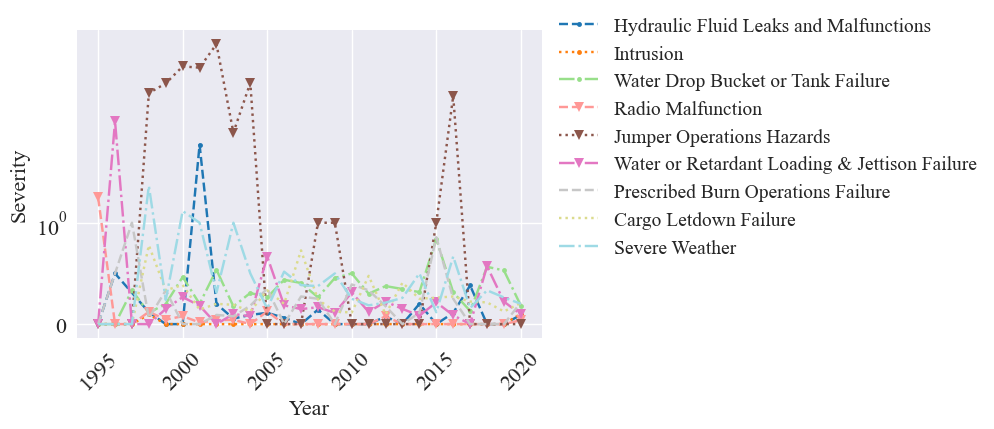

In [33]:
plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="", yscale='log', time_name='Year', show_std=False, save=False)

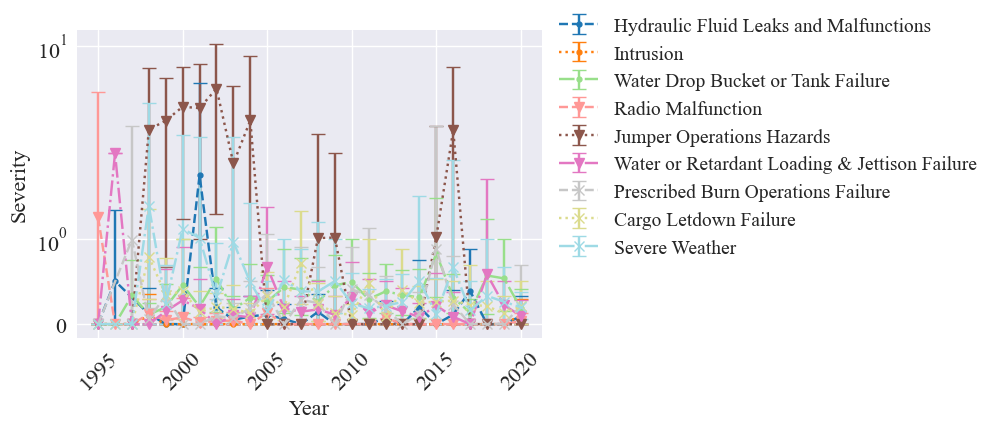

In [34]:
metric_percentage = {hazard: full_metrics.at[hazard, 'F1'] for hazard in hazards_for_analysis}
bootstrap_kwargs={'metric_percentages':metric_percentage, 'num_means':1000, 'CI_interval':95}
plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="", yscale='log', time_name='Year', show_std=False, save=False, bootstrap=True, bootstrap_kwargs=bootstrap_kwargs)

next, we graph the average severity over the years:

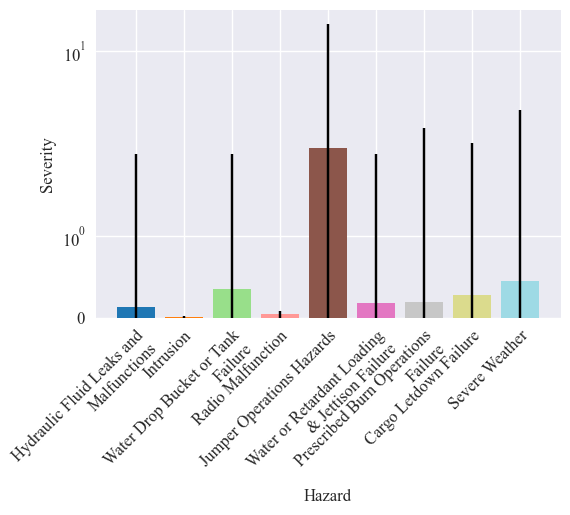

In [35]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="", save=False, yscale="log", legend=False, fontsize=12, error_bars='CI')

### Frequency Graphs

Now we graph the time series of hazard frequency:

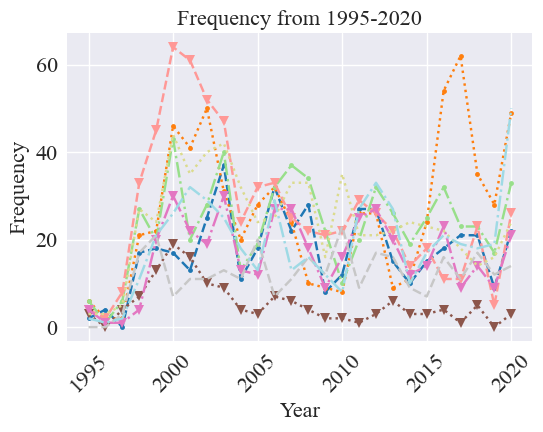

In [36]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False, save=False, legend=False)

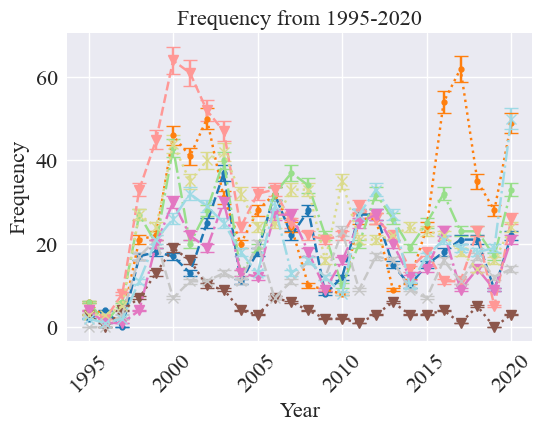

In [37]:
false_pos = {hazard: 1-full_metrics.at[hazard, 'Precision'] for hazard in hazards_for_analysis}
false_neg= {hazard: 1-full_metrics.at[hazard, 'Recall'] for hazard in hazards_for_analysis}
#interval_kwargs = {'false_pos_rate':false_pos, 'false_neg_rate':false_neg}
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False, save=False, legend=False, interval=True)#, interval_kwargs=interval_kwargs)

As a comparison, we also graph the rate:

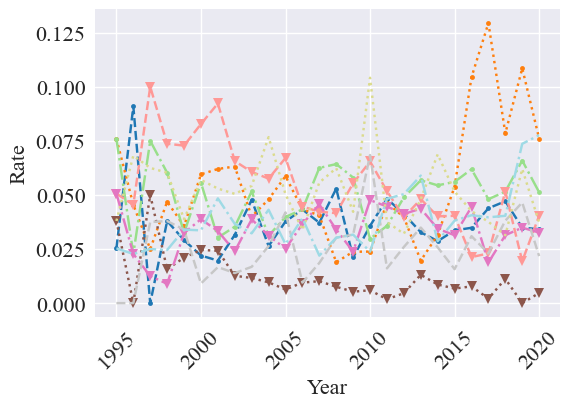

In [38]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="", time_name="Year", scale=False, save=False, legend=False)

### Pie Charts

pie charts are graphed for the region and aircraft type categorical variables. Other variables of interest could include 'Manufacturer', 'Model', and 'Mission Type'.

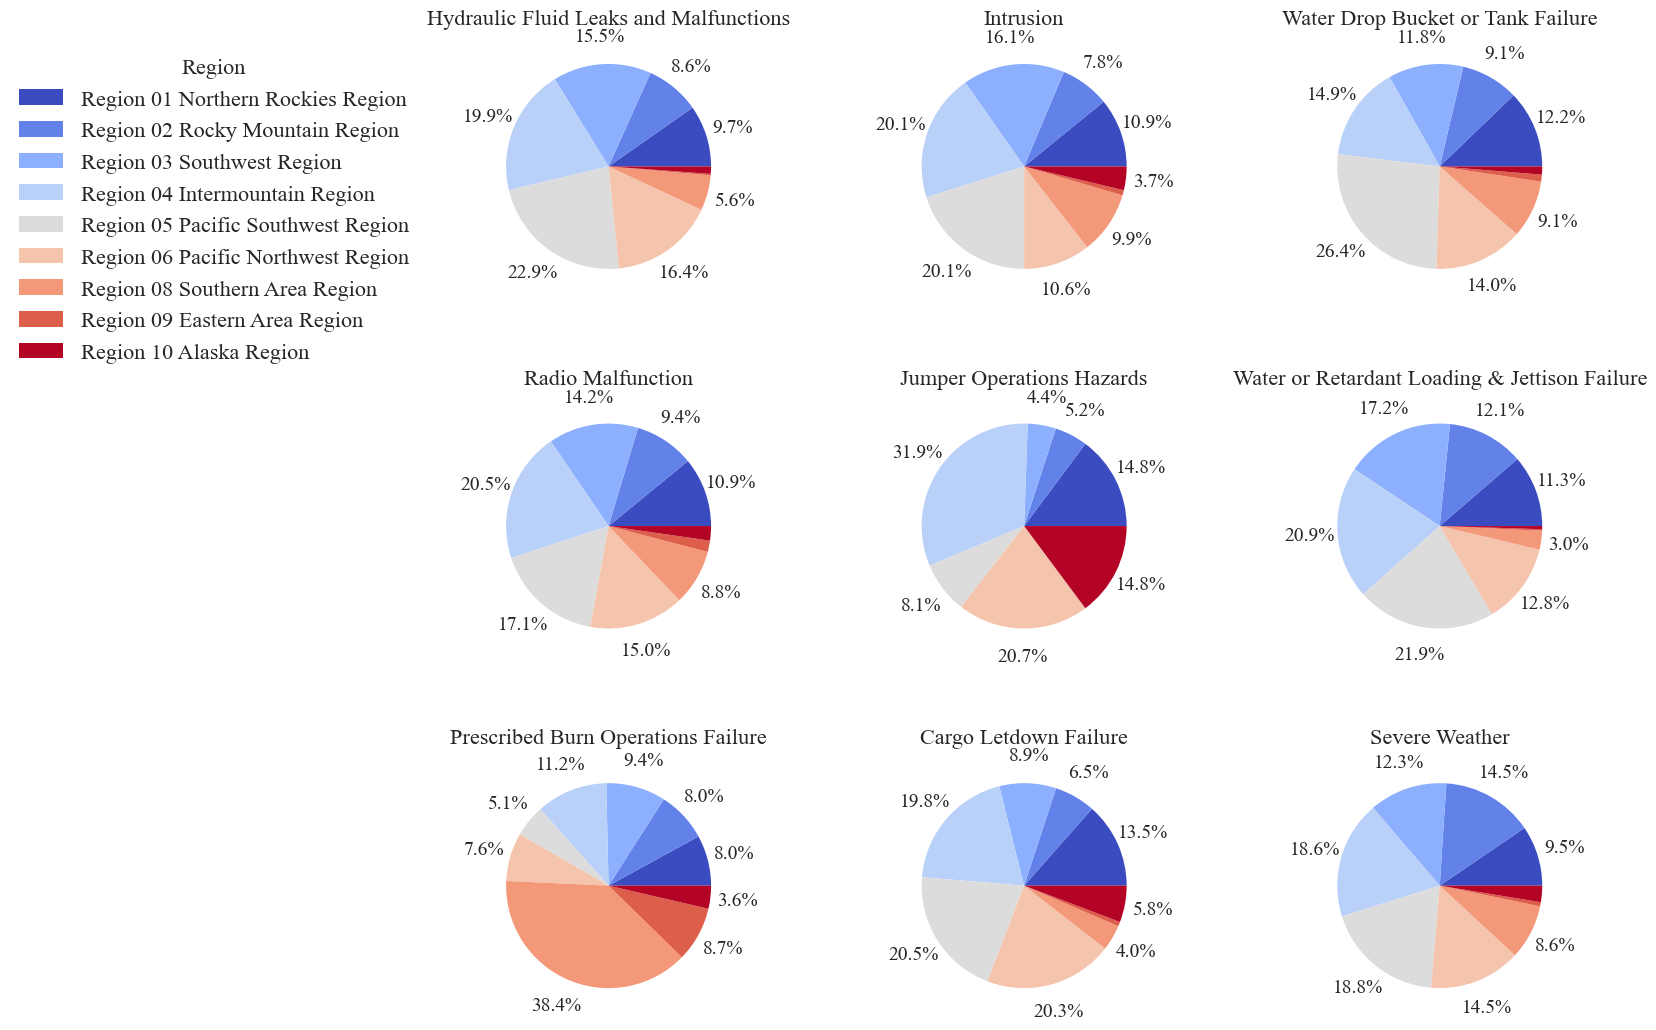

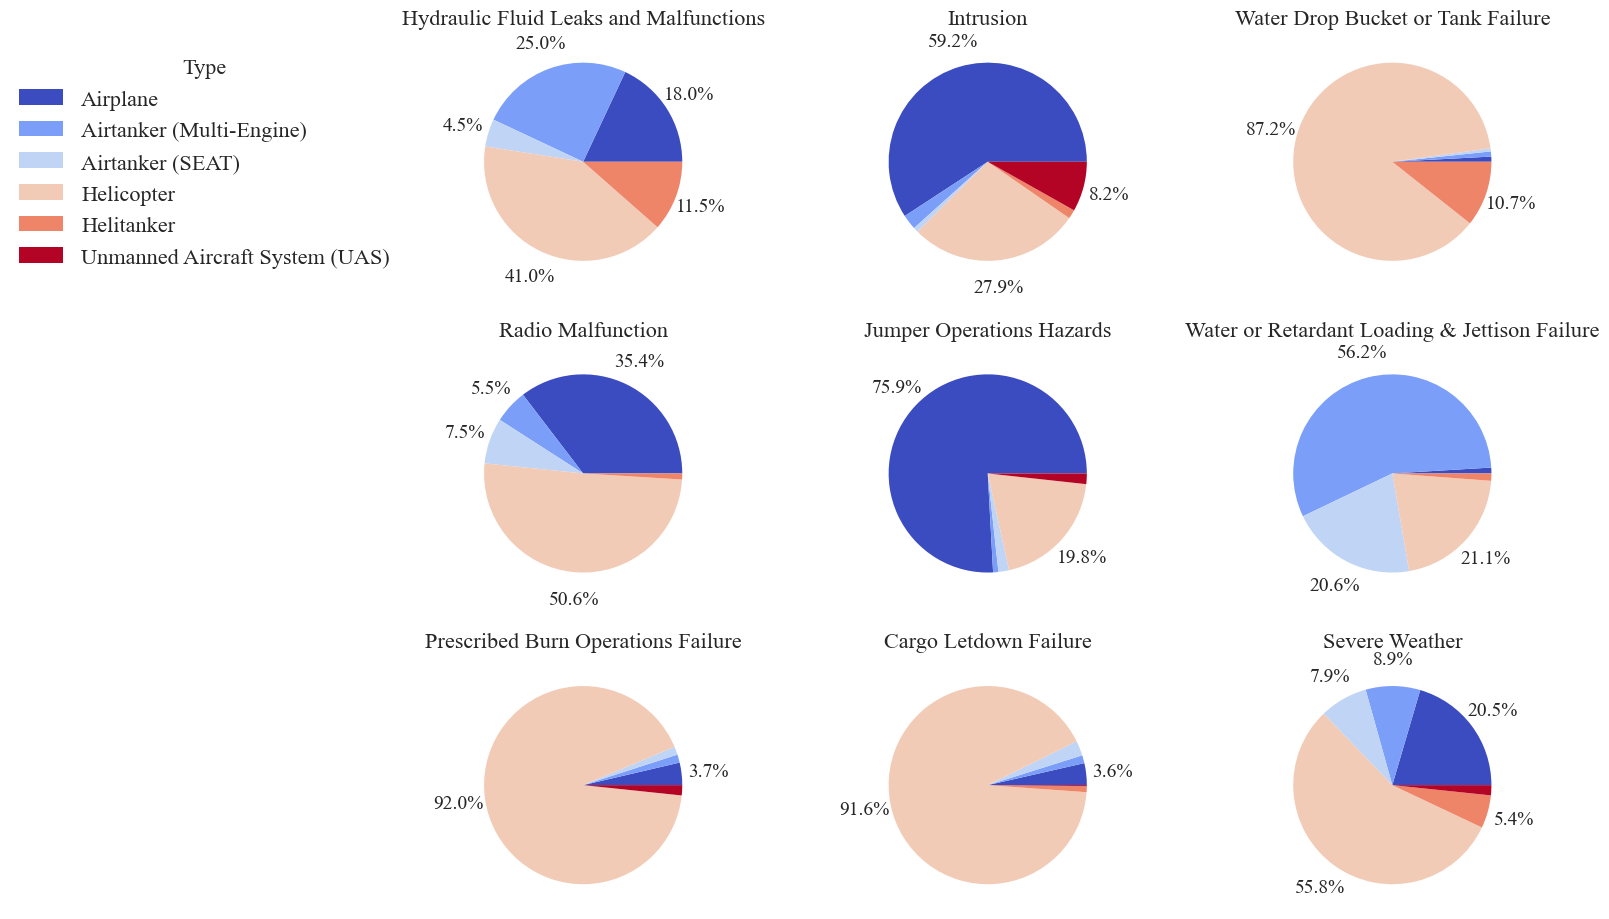

In [39]:
predictors = ['region_corrected', 'Type']
pie_kwargs = {'pctdistance':1.27}
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
        padding = -4
    else:
        predictor_label = None
        padding = 0
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label, save=False, padding=padding, pie_kwargs=pie_kwargs)

# Secondary Analysis

The secondary analysis is performed to determine if trends in the graphic analysis are statistically significant. Additionally a risk matrix is produced in this part of the analysis. This step includes:
- chi-squared analysis
- ANOVA 
- Risk matrix

### Chi-Squared Analysis

The chi-squared analysis determines if the distribution of a categorical variable, such as region, is dependent on another variable, such as the presence of a hazard. Essentially this test can determine if a hazard occurs more or less often in a certain categorical variable condition (e.g., a specific region) when compared to the complete dataset. Here we run the chi-squared test for region and aircraft type over each hazard.

To do this, we must first add hazard occurrence to the preprocessed dataframe:

In [40]:
#add hazard values to preprocessed_df
preprocessed_df = add_hazards_to_docs(preprocessed_df, "Tracking #", docs)

Now we run the chi-squared tests, which out put a statistics dataframe and a counts dataframe

In [41]:
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stats_df, count_dfs = chi_squared_tests(preprocessed_df, hazards, predictors, pred_dict)

c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:7421: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:7421: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:7418: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:7421: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:7421: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:7418: RuntimeWarning: divi

The resulting stats_df contains the chi-squared statistic an p-value for each hazard and predictor. A significant p-value indicates the distribution of the predictor across reports with the hazard is different than the distribution of the predictor accross reports without the hazard.

In [42]:
stats_df

Predictor                                     Region              \
Measure                                        p-val chi-squared   
Hydraulic Fluid Leaks and Malfunctions         0.001      28.908   
Intrusion                                      0.004      24.521   
Water Drop Bucket or Tank Failure              0.002      26.431   
Radio Malfunction                              0.018      19.994   
Jumper Operations Hazards                      0.000     116.608   
Water or Retardant Loading & Jettison Failure  0.000      50.256   
Prescribed Burn Operations Failure             0.000     467.884   
Cargo Letdown Failure                          0.000      53.263   
Severe Weather                                 0.009      22.069   

Predictor                                     Aircraft Type              
Measure                                               p-val chi-squared  
Hydraulic Fluid Leaks and Malfunctions                  0.0     134.778  
Intrusion                                               0.0    1136.508  
Water Drop Bucket or Tank Failure                       0.0     462.073  
Radio Malfunction                                       0.0     194.557  
Jumper Operations Hazards                               0.0     249.196  
Water or Retardant Loading & Jettison Failure           0.0     936.333  
Prescribed Burn Operations Failure                      0.0     194.023  
Cargo Letdown Failure                                   0.0     391.816  
Severe Weather                                          0.0      27.198

In [43]:
print(stats_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
Predictor & \multicolumn{2}{l}{Region} & \multicolumn{2}{l}{Aircraft Type} \\
Measure &  p-val & chi-squared &         p-val & chi-squared \\
\midrule
Hydraulic Fluid Leaks and Malfunctions        &  0.001 &      28.908 &           0.0 &     134.778 \\
Intrusion                                     &  0.004 &      24.521 &           0.0 &    1136.508 \\
Water Drop Bucket or Tank Failure             &  0.002 &      26.431 &           0.0 &     462.073 \\
Radio Malfunction                             &  0.018 &      19.994 &           0.0 &     194.557 \\
Jumper Operations Hazards                     &  0.000 &     116.608 &           0.0 &     249.196 \\
Water or Retardant Loading \& Jettison Failure &  0.000 &      50.256 &           0.0 &     936.333 \\
Prescribed Burn Operations Failure            &  0.000 &     467.884 &           0.0 &     194.023 \\
Cargo Letdown Failure                         &  0.000 &      53.263 &           0.0 &     391.816 \\


To futher examine these differences, we display the counts df. Negative count values indicate the condition occurs less there than expected, whereas positive values have the condition occur more. For example, there are more reports with hydraulic fluid leaks in region 5 than expected.

In [44]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                                        Present                                       
Hydraulic Fluid Leaks and Malfunctions        0                                -10.638116   
                                              1                                 10.638116   
Intrusion                                     0                                  9.034818   
                                              1                                 -9.034818   
Water Drop Bucket or Tank Failure             0                                -25.347383   
                                              1                                 25.347383   
Radio Malfunction                             0                                 28.822006   
                                              1                                -28.822006   
Jumper Operations Hazards                     0                                 16.157995   
                                              1                                -16.157995   
Water or Retardant Loading & Jettison Failure 0                                 -4.967652   
                                              1                                  4.967652   
Prescribed Burn Operations Failure            0                                 47.203888   
                                              1                                -47.203888   
Cargo Letdown Failure                         0                                  6.194965   
                                              1                                 -6.194965   
Severe Weather                                0                                 11.201737   
                                              1                                -11.201737   

                                                       Region 04 Intermountain Region  \
Hazard                                        Present                                   
Hydraulic Fluid Leaks and Malfunctions        0                            -12.806310   
                                              1                             12.806310   
Intrusion                                     0                            -13.801928   
                                              1                             13.801928   
Water Drop Bucket or Tank Failure             0                             17.113059   
                                              1                            -17.113059   
Radio Malfunction                             0                            -15.149869   
                                              1                             15.149869   
Jumper Operations Hazards                     0                            -20.503944   
                                              1                             20.503944   
Water or Retardant Loading & Jettison Failure 0                            -15.392638   
                                              1                             15.392638   
Prescribed Burn Operations Failure            0                             19.697634   
                                              1                            -19.697634   
Cargo Letdown Failure                         0                            -10.952673   
                                              1                             10.952673   
Severe Weather                                0                             -4.655565   
                                              1                              4.655565   

                                                       Region 06 Pacific Northwest Region  \
Hazard                                        Present                                       
Hydraulic Fluid Leaks and Malfunctions        0                                 -5.569277   
                                              1                                  5.569277   
Intrusion                                

Helicopter    Airplane  \
Hazard                                        Present                           
Hydraulic Fluid Leaks and Malfunctions        0         51.354075   15.874432   
                                              1        -51.354075  -15.874432   
Intrusion                                     0        180.330412 -218.654530   
                                              1       -180.330412  218.654530   
Water Drop Bucket or Tank Failure             0       -207.010517  124.825512   
                                              1        207.010517 -124.825512   
Radio Malfunction                             0         41.409290  -72.800414   
                                              1        -41.409290   72.800414   
Jumper Operations Hazards                     0         48.721297  -58.533025   
                                              1        -48.721297   58.533025   
Water or Retardant Loading & Jettison Failure 0        132.920245   87.176799   
                                              1       -132.920245  -87.176799   
Prescribed Burn Operations Failure            0       -115.367222   55.407458   
                                              1        115.367222  -55.407458   
Cargo Letdown Failure                         0       -239.655565  111.669030   
                                              1        239.655565 -111.669030   
Severe Weather                                0        -10.659947    7.550872   
                                              1         10.659947   -7.550872   

                                                       Airtanker (Multi-Engine)  \
Hazard                                        Present                             
Hydraulic Fluid Leaks and Malfunctions        0                      -48.860489   
                                              1                       48.860489   
Intrusion                                     0                       78.555255   
                                              1                      -78.555255   
Water Drop Bucket or Tank Failure             0                       79.144371   
                                              1                      -79.144371   
Radio Malfunction                             0                       60.108836   
                                              1                      -60.108836   
Jumper Operations Hazards                     0                       18.098558   
                                              1                      -18.098558   
Water or Retardant Loading & Jettison Failure 0                     -177.905187   
                                              1                      177.905187   
Prescribed Burn Operations Failure            0                       39.040953   
                                              1                      -39.040953   
Cargo Letdown Failure                         0                       78.635487   
                                              1                      -78.635487   
Severe Weather                                0                       26.059278   
                                              1                      -26.059278   

                                                       Airtanker (SEAT)  \
Hazard                                        Present                     
Hydraulic Fluid Leaks and Malfunctions        0                3.288901   
                                              1               -3.288901   
Intrusion                                     0               30.063023   
                                              1              -30.063023   
Water Drop Bucket or Tank Failure             0               28.535973   
                                              1              -28.535973   
Radio Malfunction                             0              -10.729504   
                                              1               10.729504   
Jumper Operations Hazar

### ANOVA 

An ANOVA is performed to determine if there is a statistically siginificant difference in severity between the hazards.

To perform this, we first format the data into an AOV_df, which allows us to easily run the test.

In [45]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

Now that the data is formatted, we run the test. The Welch ANOVA is chosen because the data does not meet the criteria for a conventional ANOVA (same variances/sample sizes). The first ANOVA test we run checks if the severity between hazard and non-hazard documents is different for each hazard and the anova result is displayed.

In [46]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leaks and Malfunctions,1,478.828,2.661,0.103,0.000
0,Intrusion,1,5701.889,358.199,0.000,0.002
0,Water Drop Bucket or Tank Failure,1,699.347,17.853,0.000,0.001
0,Radio Malfunction,1,1487.105,120.882,0.000,0.002
0,Jumper Operations Hazards,1,137.102,26.684,0.000,0.045
0,Water or Retardant Loading & Jettison Failure,1,503.159,0.870,0.351,0.000
0,Prescribed Burn Operations Failure,1,336.694,0.272,0.602,0.000
0,Cargo Letdown Failure,1,739.366,5.336,0.021,0.000
0,Severe Weather,1,512.122,11.595,0.001,0.002


Next we run an anova between all of the hazards, resulting in one F value. This test determines if there is a difference in severity between any of the hazards.

In [47]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [48]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,1266.871,33.264,0.0,0.096


In [49]:
print(aov.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  Source &  ddof1 &     ddof2 &       F &  p-unc &    np2 \\
\midrule
0 &  hazard &      8 &  1266.871 &  33.264 &    0.0 &  0.096 \\
\bottomrule
\end{tabular}



Since the ANOVA yeiled a significant result, we want to further determine which hazards are more severe than others. We do this using pairwise testing, in this case the gameshowell test.

In [50]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

To simplify the results output, we filter out the results to only show hazard pairs that have a significant difference in severity

In [51]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [52]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Cargo Letdown Failure,Intrusion,674.026,8.586,0.000,0.476
Cargo Letdown Failure,Jumper Operations Hazards,138.706,-4.914,0.000,-0.462
Cargo Letdown Failure,Radio Malfunction,850.972,7.120,0.000,0.394
Hydraulic Fluid Leaks and Malfunctions,Jumper Operations Hazards,141.275,-5.268,0.000,-0.512
Hydraulic Fluid Leaks and Malfunctions,Severe Weather,852.553,-3.627,0.009,-0.236
Hydraulic Fluid Leaks and Malfunctions,Water Drop Bucket or Tank Failure,835.475,-3.681,0.008,-0.229
Intrusion,Jumper Operations Hazards,137.067,-5.619,0.000,-0.524
Intrusion,Prescribed Burn Operations Failure,322.167,-4.002,0.003,-0.274
Intrusion,Severe Weather,504.976,-6.002,0.000,-0.354


In [53]:
print(post_hoc.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                                              B &        df &      T &   pval &  hedges \\
A                                      &                                                &           &        &        &         \\
\midrule
Cargo Letdown Failure                  &                                      Intrusion &   674.026 &  8.586 &  0.000 &   0.476 \\
Cargo Letdown Failure                  &                      Jumper Operations Hazards &   138.706 & -4.914 &  0.000 &  -0.462 \\
Cargo Letdown Failure                  &                              Radio Malfunction &   850.972 &  7.120 &  0.000 &   0.394 \\
Hydraulic Fluid Leaks and Malfunctions &                      Jumper Operations Hazards &   141.275 & -5.268 &  0.000 &  -0.512 \\
Hydraulic Fluid Leaks and Malfunctions &                                 Severe Weather &   852.553 & -3.627 &  0.009 &  -0.236 \\
Hydraulic Fluid Leaks and Malfunctions &              Water Drop Bucket or Ta

### Risk Matrix

To display this infomation in an accessible format, we place the hazards on a risk matrix according to USFS guidelines. 

First, configure the plotting parameters:

In [54]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

Next, assign likelihood and severity categories using the numeric hazard severity and rate values previously calculated:

In [55]:
severities = table['Severity']
severities.index = table['Hazards']
severities_raw = severities[hazards]
severities_raw = severities_raw.to_dict()
#severities = get_SAFECOM_severity_FAA(severities_raw)
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()
#likelihood = get_likelihood_FAA(rates)

In [56]:
severities_USFS = get_SAFECOM_severity_USFS(severities_raw)
likelihood = get_likelihood_USFS(rates)

Now we can plot the risk matrix using the defined categories:

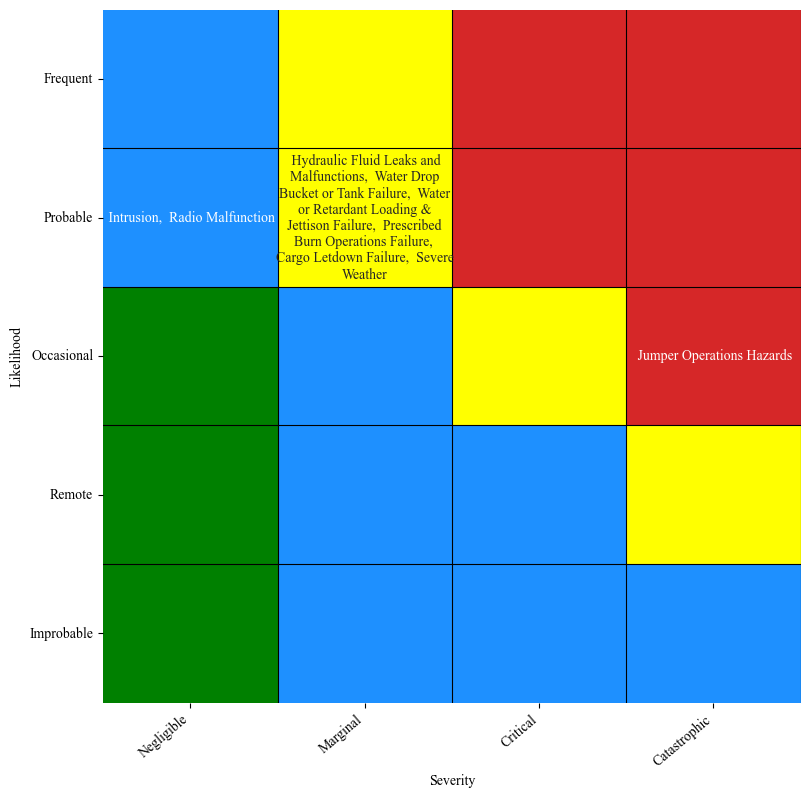

In [57]:
plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,9), save=False, results_path="SAFECOM_JAIS_USFS_risk_matrix", fontsize=10, max_chars=30, title=False)

# Situation Specific Risk Matrices

To demonstrate the usefulness of this framework, we present a case study of situation specific risk matrices developed from SAFECOM reports. 

Here we define the functions needed to create these risk matrices. They include filtering the dataframe based on a set of conditions, then recalculating the hazard rate and severity for each hazard.

In [58]:
def filter_df(df, filters):
    for col in filters:
        df = df.dropna(subset=[col])
        df = df[df[col].apply(lambda x: filters[col] in x)].reset_index(drop=True)
    return df

In [59]:
def get_custom_rm(df, filters, hazard_file, results_file, keep_hazards=[], save=False):
    preprocessed_df = filter_df(df, filters)
    frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)
    rates = calc_rate(frequency)
    _, severities = calc_severity_per_hazard(docs, preprocessed_df, id_field='Tracking #')
    #replace nans with 0
    severities = {hazard:severities[hazard] if (not np.isnan(severities[hazard])) else 0 for hazard in severities}
    if keep_hazards == []: keep_hazards = [hazard for hazard in docs]
    #rm extra hazards
    severities = {hazard: severities[hazard] for hazard in severities if hazard in keep_hazards}
    rates = {hazard: rates[hazard] for hazard in rates if hazard in keep_hazards}
    severities_USFS = get_SAFECOM_severity_USFS(severities)
    likelihood = get_likelihood_USFS(rates)
    filters_string = ""
    for key in filters:
        filters_string += key.replace(" ", "_") 
        filters_string += filters[key].replace(" ", "_")
    results_path = 'risk_matrix_'+filters_string+'.pdf'
    plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,7), save=save, results_path=results_path, fontsize=10, max_chars=28, title=False)

### Example 1: Aerial commander flying an Aero Commander airplane in California

We define the hazards to include on the custom risk matrix:

In [60]:
keep_hazards = ['Hydraulic Fluid Leaks and Malfunctions','Intrusion','Airspace Control Hazards','Radio Malfunction','Jumper Operations Hazards',
                'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Landing Gear Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']

Next we specify the featues that define the scenario and get the custom risk matrix:

100%|██████████| 26/26 [00:02<00:00, 11.82it/s]
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


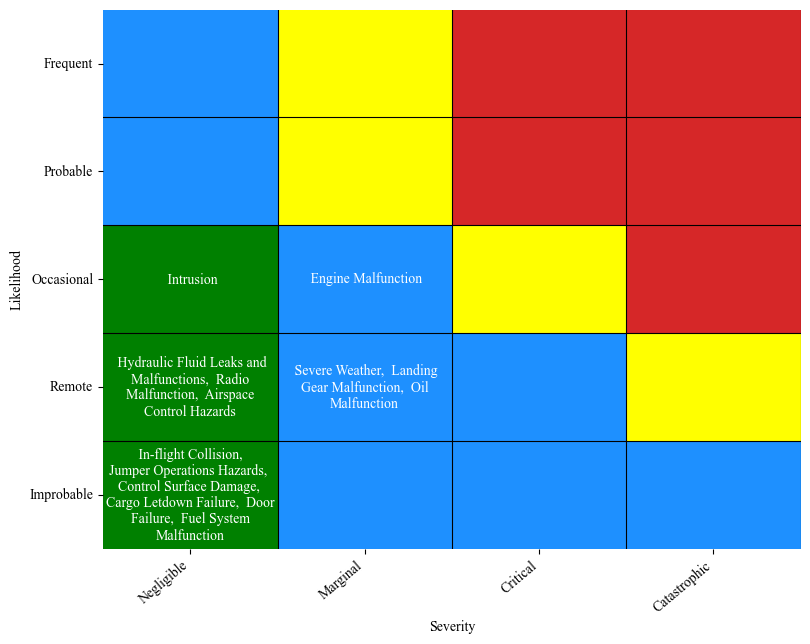

In [61]:
filters ={"Mission Type":'Fire, Air Attack',
          "Type":'Airplane',
         "Manufacturer":'Aero Commander',
         "region_corrected":'Region 05 Pacific Southwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 2: Air Tanker flying a redardant drop mission with a Lockheed multi-engine in Oregon

Again, specify the filters that define the scenario then get the risk matrix:

100%|██████████| 26/26 [00:01<00:00, 20.53it/s]
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


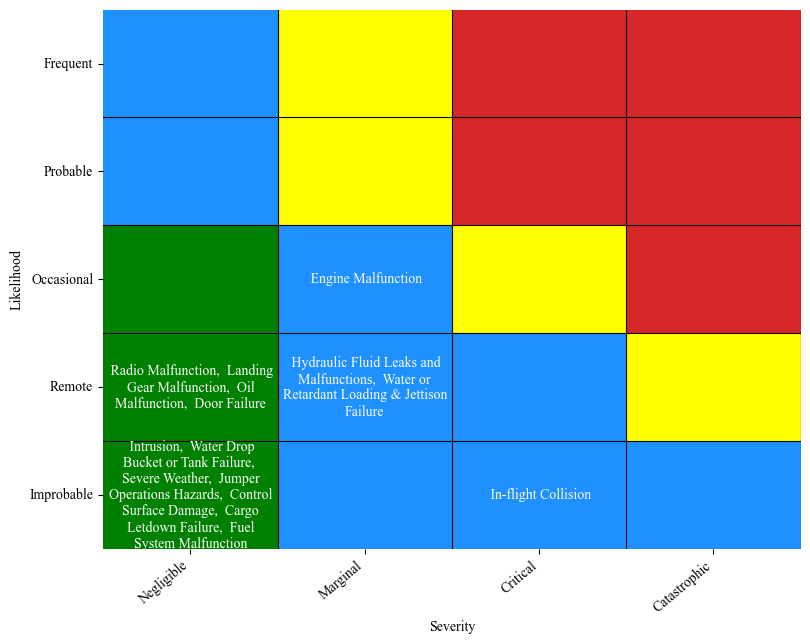

In [62]:
filters ={"Mission Type":'Fire, Retardant Drop (Airtanker)',
         "Type":'Airtanker (Multi-Engine)',
          "Manufacturer": "Lockheed",
         'region_corrected':'Region 06 Pacific Northwest Region'}
keep_hazards = ['Hydraulic Fluid Leaks and Malfunctions','Intrusion','Water Drop Bucket or Tank Failure','Radio Malfunction','Jumper Operations Hazards',
                'Water or Retardant Loading & Jettison Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Landing Gear Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 3: Pilot flying a Bell Helicopter for reconnaisance in Texas

In addition to specifying the filters, for this risk matrix we also define a new list of hazards that are more relevant to this scenario:

100%|██████████| 26/26 [00:01<00:00, 24.85it/s]
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


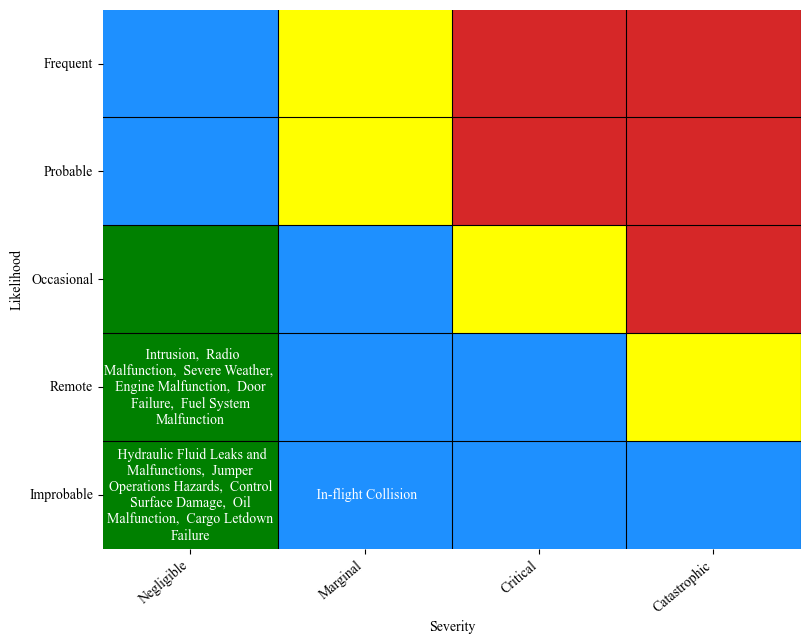

In [63]:
filters ={"Mission Type":'Fire, Reconnaissance',
         "Type":'Helicopter',
          "Manufacturer": "Bell",
          #"Model":"600",#includes 600
          'region_corrected':'Region 08 Southern Area Region'}
keep_hazards = ['Hydraulic Fluid Leaks and Malfunctions','Intrusion', 'Radio Malfunction','Jumper Operations Hazards',
                'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)